# Check GPU

In [1]:
!nvidia-smi

Wed Oct 19 15:09:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 470.63.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:1A:00.0 Off |                    0 |
| N/A   36C    P0    25W / 250W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A40          Off  | 00000000:1B:00.0 Off |                    0 |
|  0%   

# Import Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning)
import shutup; shutup.please()

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns  # for heatmaps
import matplotlib.pyplot as plt
%matplotlib inline
import os
import time
import random

In [4]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard import SummaryWriter

In [5]:
from data.load_data import *  #### functions to load paired data(from same modality or different modalities)
from data import *
from data.transform.utils import *

from models.cnn import ResNet, Block
from simmim.vision_transformer import ViT
from models.cnn import ResNet
from train import train, evaluation, save_model

# Set Device and Seed

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
source_dir = "/nfs-share/aai30/projects/transformer_baseline"

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed = 42

In [7]:
joint = 'joint_width'                  # option: 'first','second','joint' (used in finetuning, consider data from first receiver, or 2nd receiver, or both)
data_type =  'spectrogram'            # 'spectrogram', 'time-series'
val_method = 'random'                  # validation method; option:   'personid' ,  'roomid', 'expid'  ,  'random'
num_workers = 4
y_sampling = None                # option: None,'oversampling','undersampling'
activities = []
sampling = 'weight'
batch_size = 64
namings = ['exp_15_pwr_spectrograms', 'exp_10_amp_spec_only_STFT', 'exp_11_phdiff_spec_only_STFT']#, 'MarkovTransitionField']#, 'exp_7_amp_spec_only', 'exp_9_phdiff_spec_only'] # 'exp_16_kinect_spectrograms']

# Import Data

In [8]:
multimodal_data = import_multiple_modalities( data_type = data_type, data_directory = "/local/scratch/opera_spec", namings = namings,partition_str="person_Five")

/local/scratch/opera_spec/exp_15_pwr_spectrograms/
Importing Data ['stand', 'sit', 'laydown', 'standff', 'bodyrotate', 'walk']
>>>>>

KeyboardInterrupt: 

In [ ]:
data_type = 'multimodal_spectrogram'
views = 'associated'
axis = 3

if data_type == 'multimodal_spectrogram':
    X_train, X_test, y_train, y_test = split_multimodal_data(multimodal_data, views = views, axis = axis)

    X_train, X_test, y_train, y_test, lb = filtering_activities_and_label_encoding(X_train, X_test, y_train, y_test, 
                                                                                       activities)

In [ ]:
samplings = [1,
             int(0.025 * len(X_train) // 6),
             int(0.05 * len(X_train) // 6),
             int(0.10 * len(X_train) // 6),
             int(0.15 * len(X_train) // 6),
             int(0.20 * len(X_train) // 6),
             'weight'  ## weight = full training labels used  
             ]

sampling = samplings[-1]

train_loader, valid_loader, class_weight = combine1(X_train, X_test, y_train, y_test, 
                                                    sampling, lb, batch_size, num_workers,
                                                    y_sampling='None')

X_train:  (2317, 1, 224, 1120) 	y_train:  (2317,) 	X_test:  (580, 1, 224, 1120) 	y_test:  (580,)


Text(0.5, 1.0, 'Distribution of human activities')

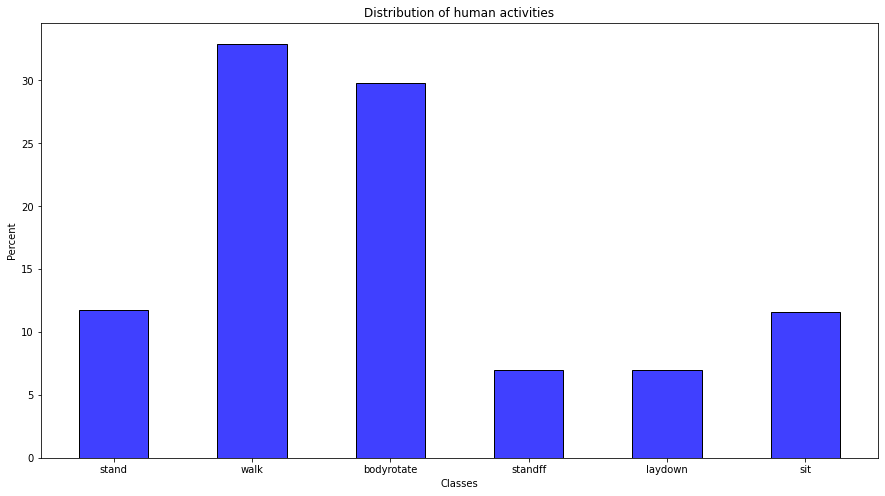

In [ ]:
plt.figure(figsize = (15, 8)) 
sns.histplot(y_train, x = lb.inverse_transform(y_train), stat = 'percent', shrink = 0.5, discrete = True, color = 'blue')
plt.xlabel('Classes')
plt.title('Distribution of human activities')

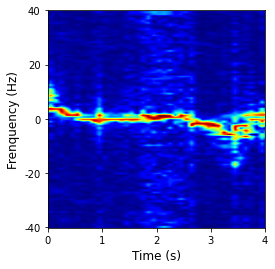

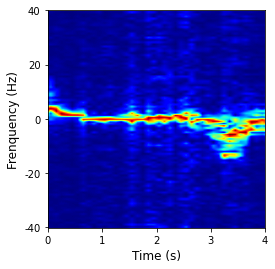

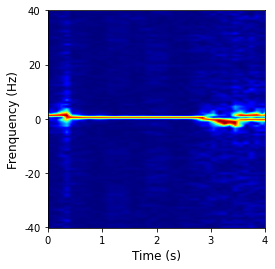

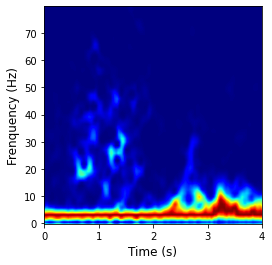

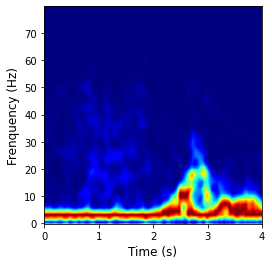

In [ ]:
x_positions = [0, 56, 112, 56*3, 56*4]
x_labels = [0, 1, 2, 3, 4]

y_positions = [0, 28, 28*2, 28*3, 28*4, 28*5, 28*6, 28*7]

csi_labels = [0, 10, 20, 30, 40, 50, 60, 70]
pwr_labels = [-40, -20, 0, 20, 40]

my_yticks = ['PWR1', 'PWR2', 'PWR3', 'AMP_STFT_NUC1', 'AMP_STFT_NUC2', 'PHDIFF_STFT_NUC1', \
             'PHDIFF_STFT_NUC2', 'MTF_DIFF_N1', 'MTF_DIFF_N2', 'MTF_DWT_N1', 'MTF_DWT_N2', \
             'AMP_SCAL_N1', 'AMP_SCAL_N2', 'AMP_DIFF_N1', 'AMP_DIFF_N2']
        
if (data_type == 'multimodal_spectrogram'):
    for i in range(int(train_loader.dataset[0][0].shape[-1] // 224)):
        if my_yticks[i].find('PWR') == 0:
            plt.figure()
            plt.imshow(X_train[0][0][0:224, 224*i:(224*(i+1))], cmap = 'jet', origin='lower')
            plt.xticks(x_positions, x_labels)
            plt.yticks(x_positions, pwr_labels)
            plt.xlabel('Time (s)', fontsize = 12)
            plt.ylabel('Frenquency (Hz)', fontsize = 12)
            plt.show()
        else:
            plt.figure()
            plt.imshow(X_train[0][0][0:224, 224*i:(224*(i+1))], cmap = 'jet', origin='lower')
            plt.xticks(x_positions, x_labels)
            plt.yticks(y_positions, csi_labels)
            plt.xlabel('Time (s)', fontsize = 12)
            plt.ylabel('Frenquency (Hz)', fontsize = 12)
            plt.show()

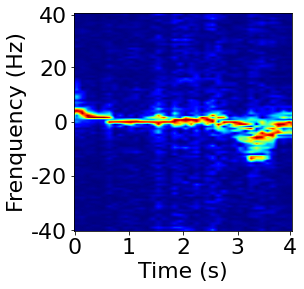

In [ ]:
##### plt.figure()
plt.imshow(X_train[0][0][0:224, 224:224*2], cmap = 'jet', origin='lower')
positions = [0, 56, 112, 168, 222]
x_labels = [0, 1, 2, 3, 4]
y_labels = [-40, -20, 0, 20, 40]
plt.xticks(positions, x_labels, fontsize = 22)
plt.yticks(positions, y_labels, fontsize = 22)
plt.xlabel('Time (s)', fontsize = 22)
plt.ylabel('Frenquency (Hz)', fontsize = 22)
plt.show()

<Figure size 432x288 with 0 Axes>

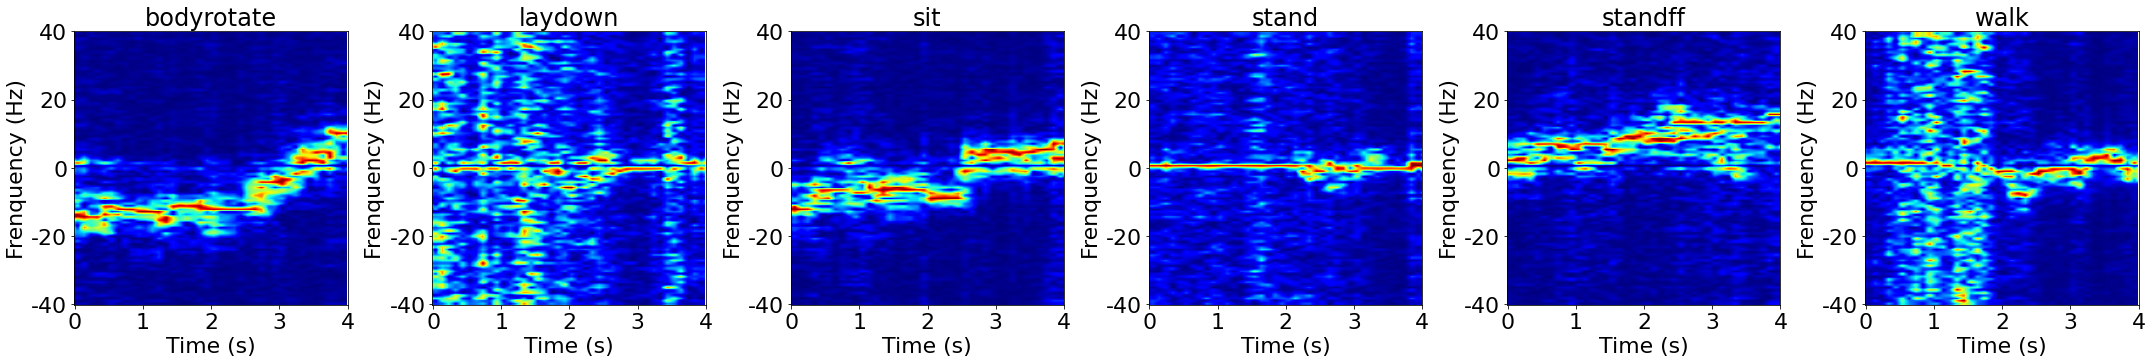

In [ ]:
num_col = 6
num_row = 1

x_positions = [0, 56, 112, 56*3, 56*4]
x_labels = [0, 1, 2, 3, 4]
y_positions = [0, 28, 28*2, 28*3, 28*4, 28*5, 28*6, 28*7]
y_labels = [0, 10, 20, 30, 40, 50, 60, 70]
y_labels = [-40, -20, 0, 20, 40]

i = 0
labs, indices = np.unique(y_train[600:], return_index=True)

plt.figure()
fig, axs = plt.subplots(num_row, num_col, figsize = (30, 30))

for j in range(num_col):
    axs[j].imshow(X_train[400:][indices[j]][0][:, 224 * i : 224 * (i + 1)], cmap = 'jet', origin = 'lower')
    axs[j].set_xticks(x_positions)
    axs[j].set_xticklabels(x_labels, fontsize = 22)
    axs[j].set_yticks(x_positions)
    axs[j].set_yticklabels(y_labels, fontsize = 22)
    axs[j].set_title('{}'.format(lb.classes_[j]), fontsize = 24)
    axs[j].set_xlabel('Time (s)', fontsize = 22)
    axs[j].set_ylabel('Frenquency (Hz)', fontsize = 22)

plt.tight_layout()
plt.show()

# Building the model

### Parameters

In [ ]:
from models.hybridvit import *

In [ ]:
from models.transformer import VisionTransformer

In [ ]:
# Model parameters

def get_model(network):

    if network == 'vit':
        img_size      = [224, train_loader.dataset[0][0].shape[2]]
        patch_size    = [224, 224] # [32,32]  [16,16]
        in_channels   = 1
        n_classes     = 6
        embed_dim     = 512  # 384 # 512 #2048
        depth         = 3   #6  4 
        n_heads       = 4
        qkv_bias      = False
        attn_p        = 0.1
        p             = 0.1
        mlp_ratio     = 1.0
        
        model  = VisionTransformer(img_size, patch_size, in_channels, n_classes, embed_dim = embed_dim, depth = depth, n_heads = n_heads, qkv_bias = qkv_bias, attn_p = attn_p, p = p, 
                                    mlp_ratio = mlp_ratio)
    
    if network == 'hybridvit':
        img_size = (224, train_loader.dataset[0][0].shape[2])
        patch_size = 224 # [32,32]  [16,16]
        in_channels = 1
        num_classes = 6
        dim = 512  # 384 # 512 #2048
        depth = 3   #6  4 
        n_heads = 4
        mlp_dim = 512
        dropout = 0.1
        emb_dropout = 0.1
        n_filter_list = [1, 16, 32, 64]
        seq_pool = False
        positional_embedding = True

        model  = HybridViT(
            image_size = img_size, 
            patch_size = patch_size, 
            num_classes = num_classes, 
            dim = dim, 
            depth = depth, 
            heads = n_heads,
            mlp_dim = mlp_dim,
            channels = in_channels,
            dropout = dropout,
            n_filter_list = n_filter_list,
            emb_dropout = emb_dropout,
            seq_pool = seq_pool, 
            positional_embedding = positional_embedding
        )

    if network == 'resnet':
        model = ResNet(34, Block, image_channels = 7, num_classes = 6)
        
    return model

### Training phase

16405783

In [ ]:
network = 'hybridvit'

# Name of the model to save
exp_name = 'HybridViT_STFT_PWR'

model = get_model(network)

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

11679510


In [ ]:
seed_everything(seed)

# Training settings
epochs       = 100
lr           = 1e-4
gamma        = 0.5
step_size = 3
multi_gpus = False

# Name of the model to save
exp_name = 'ResNet34_STFT_PWR'

# Get model
model = get_model(network)

#Run or multiple GPUs
if multi_gpus == True:
    model = nn.DataParallel(model, list(range(torch.cuda.device_count())), output_device = 0)
    model = model.to(f'cuda:{model.device_ids[0]}')
else:
    model = model.to(device)

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.AdamW(model.parameters(), lr = lr, weight_decay = 0.01)

# scheduler
scheduler = StepLR(optimizer, step_size = step_size, gamma = gamma)

model, record = train(model, criterion, optimizer, epochs, train_loader, valid_loader, device, exp_name, lb, embedding = 'no')

  0%|          | 0/36 [00:18<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 44.56 GiB total capacity; 1.39 GiB already allocated; 5.31 MiB free; 1.45 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
import shutil
shutil.rmtree(f'{source_dir}/logs/train/' + exp_name)
shutil.rmtree(f'{source_dir}/results/saved_models/train/' + exp_name)

FileNotFoundError: [Errno 2] No such file or directory: '/nfs-share/aai30/projects/transformer_baseline/results/saved_models/train/ResNet34_STFT_PWR'

0.889

# Count number of parameters

In [ ]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

# Load the best model

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model_dir = f'{source_dir}/results/saved_models/train/' + exp_name + '/'
model.load_state_dict(torch.load(model_dir + os.listdir(model_dir)[0]), strict = False)
model.eval()

# Model Evaluation/Visualization

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(1,epochs+1),record['train_loss'])
plt.plot(np.arange(1,epochs+1),record['val_loss'])
plt.legend(['Training Loss' , 'Validation Loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.rcParams.update({'font.size': 16})
plt.show()

metric = 'f1_macro'
plt.figure(figsize=(10,5))
plt.plot(np.arange(1,epochs+1),record['train_f1'])
plt.plot(np.arange(1,epochs+1),record['f1_macro'])
plt.legend(['Training f1' , 'Validation f1'])
plt.title(f'{metric} in {epochs} epochs (every 10 epochs from 10th epoch)-ViT',fontsize=10)
plt.ylabel('f1_macro score')
plt.xlabel('Epochs')
plt.rcParams.update({'font.size': 16})
plt.show()

In [ ]:
seed_everything(seed)
multi_gpus = False
if multi_gpus == True:
    cmtx,cls = evaluation(model.module.cpu(), valid_loader, label_encoder = lb)
else:
    cmtx,cls = evaluation(model.cpu(), valid_loader, label_encoder = lb)
    
df = ( cmtx.div( cmtx.sum(1).tolist(),axis=0)).round(2)
df.columns = df.columns.str.replace(r'predict :', '')
df.index    = df.index.str.replace(r'actual:', '')

CMAP = 'Blues'
FMT = 'g'
plt.figure(figsize=(20,10))
sns.heatmap(df,cmap=CMAP,annot=True, fmt=FMT)
plt.title('')
plt.rcParams.update({'font.size': 23})
plt.xlabel('Predicted', fontsize = 22)
plt.ylabel('True labels', fontsize = 22)
plt.show()

In [ ]:
metrics = pd.DataFrame({'accuracy': [cls['accuracy'][0]], 'precision': [cls['macro avg']['precision']], 
                        'recall': [cls['macro avg']['recall']], 'f1-score': [cls['macro avg']['f1-score']]})

if network == 'vit':
    model_parameters = pd.DataFrame({
        'img_size'      : [[224 , train_loader.dataset[0][0].shape[-1]]],
        'patch_size'    : [[224, 224]],
        'in_channels'   : 1,
        'n_classes'     : 6,
        'embed_dim'     : 512,  
        'depth'         : 3,   
        'n_heads'       : 4,
        'qkv_bias'      : False,
        'attn_p'        : 0.1,
        'p'             : 0.1,
        'mlp_ratio'     : 1.0,
    })
else:
    model_parameters = pd.DataFrame({
        'network': [network]
    })

parameters = {
    'num_parameters' : [params],
    'learning rate' : [lr],
    'optimizer' : ['AdamW'],
    'Weight decay': [str(0.01)],
    'Scheduler' : ['StepLR'],
    'Step size' : [str(step_size)],
    'Gamma' : [str(gamma)]
    }

num_parameters = pd.DataFrame(parameters)

modalities = {}
for i, modality in enumerate(my_yticks[0:7]):
    modalities['modality ' + str(i)] = [modality]
data = pd.DataFrame(modalities)

In [ ]:
record_outpath = f'{source_directory}/results/records'

def record_log(record_outpath, exp_name, metrics, model_parameters, data):
    prefix = record_outpath + '/' + exp_name
    if not os.path.isdir(prefix):
        os.mkdir(prefix)
    metrics.to_csv(prefix + '/' + 'metrics.csv') 
    model_parameters.to_csv(prefix + '/' + 'model_parameters.csv') 
    data.to_csv(prefix + '/' + 'data.csv')
    num_parameters.to_csv(prefix + '/' + 'num_params.csv')
    print(f'Records saved in {exp_name} folder')

record_log(record_outpath, exp_name, metrics, model_parameters, data)

# Visualize Embeddings

In [ ]:
import sklearn

for x, y in valid_loader:
    x = x.to(device)
    
    with torch.no_grad():
        model = model.to(device)
        pred = model(x)
    break


tsne_model = sklearn.manifold.TSNE(perplexity = 30.0, verbose = 1, random_state = seed)
tsne_projections = tsne_model.fit_transform(pred.cpu().data)  

labels_argmax =y # np.argmax(y, axis=1)
unique_labels = np.unique(labels_argmax)

plt.figure(figsize=(14,8))
graph = sns.scatterplot(
    x = tsne_projections[:,0], y = tsne_projections[:,1],
    hue=labels_argmax,
    palette=sns.color_palette("hsv", len(unique_labels)),
    s=200,
    alpha=1.0,
    rasterized=True
)
plt.xticks([], [])
plt.yticks([], [])
plt.rcParams.update({'font.size': 22})    

label_list_full_name = ['bodyrotate', 'laydown','sit','stand','standff','walk']
plt.legend(loc='lower left', bbox_to_anchor=(0.25, -0.3), ncol=2, markerscale=4)
legend = graph.legend_
for j, label in enumerate(unique_labels):
    legend.get_texts()[j].set_text(label_list_full_name[label]) 

# Visualize attention

In [ ]:
import ipywidgets
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

In [ ]:
def get_last_attention(backbone, x, att_layer):
    """Get the attention weights of CLS from the last self-attention layer.

    Very hacky!

    Parameters
    ----------
    backbone : timm.models.vision_transformer.VisionTransformer
        Instantiated Vision Transformer. Note that we will in-place
        take the `head` attribute and replace it with `nn.Identity`.

    x : torch.Tensor
        Batch of images of shape `(n_samples, 3, size, size)`.

    Returns
    -------
    torch.Tensor
        Attention weights `(n_samples, n_heads, n_patches)`.
    """
    attn_module = model.transformer.layers[att_layer][0].fn
    n_heads = attn_module.heads

    # define hook
    inp = None
    def fprehook(self, inputs):
        nonlocal inp
        inp = inputs[0]

    # Register a hook
    handle = attn_module.register_forward_pre_hook(fprehook)

    # Run forward pass
    _ = backbone(x)
    handle.remove()

    B, N, C = inp.shape
    print(inp.shape)
    qkv = attn_module.to_qkv(inp)
    print(qkv.shape)
    qkv = qkv.reshape(B, N, 3, n_heads, C // (2 * n_heads)).permute(2, 0, 3, 1, 4)
    q, k, v = qkv[0], qkv[1], qkv[2]

    attn = (q @ k.transpose(-2, -1)) * attn_module.scale
    attn = attn.softmax(dim=-1)

    return attn[:, :, 0, 1:]

In [ ]:
def threshold(attn, k=30):
    n_heads = len(attn)
    indices = attn.argsort()[:, k:]
    for head in range(n_heads):
        attn[head, indices[head]] = 0

    attn /= attn.sum(dim = 1, keepdims=True)

    return attn

In [ ]:
def create_attention_img(img, backbone, att_layer, k=30):
    """
    Create attention image.

    Parameteres
    -----------
    img : PIL.Image
        RGB image.

    Returns
    -------
    new_img : torch.Tensor
        Image of shape (n_heads, 1, height, width).
    """
    # imply parameters
    patch_size = 224

    device = next(backbone.parameters()).device
    x = img.to(device)
    attn = get_last_attention(backbone, x, att_layer)[0]  # (n_heads, n_patches)
    attn = attn / attn.sum(dim=1, keepdim=True)  # (n_heads, n_patches)
    attn = threshold(attn, k)
    attn = attn.reshape(-1, 1, int(valid_loader.dataset[0][0].shape[-1]/224))  # (n_heads, 14, 14)
    attn = F.interpolate(attn.unsqueeze(0),
        scale_factor=patch_size,
        mode="nearest"
        )[0]
    return attn

In [ ]:
def get_attention_weights(i, k, att_layer):

    img = valid_loader.dataset[i][0].reshape(1, 1, 224, valid_loader.dataset[0][0].shape[-1])
    attns = create_attention_img(img, model, att_layer, k= k).detach()[:].cpu().numpy()
    
    return img, attns

In [ ]:
i = 113
print(lb.classes_[y[i]])
print(lb.classes_[np.argmax(pred.cpu(), axis = 1)[i].item()])

In [ ]:
img, attns = get_attention_weights(i = i, k = 25, att_layer = 0)

# original image
plt.figure(figsize = (18, 18))
plt.imshow(img[0][0].numpy(), cmap = 'jet', origin='lower')
plt.axis("off")
plt.show()
kwargs = {"vmin": 0, "vmax": 1.0}

In [ ]:
num_col = 5
num_row = 3

plt.figure()
fig, axs = plt.subplots(num_row, num_col, figsize = (15, 12))

for i in range(int(img.shape[-1]/224)):
    ax = axs[i//num_col, i%num_col]
    ax.imshow(img[0][0][0:224, 224*i:(224*(i+1))], cmap = 'rainbow', origin = 'lower')
    ax.set_title('{}'.format(my_yticks[i]), fontsize = 12)

plt.tight_layout()
plt.show()

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

def visualize_attentions(attns):
    
    num_col = 1
    num_row = 4

    plt.figure()
    fig, axs = plt.subplots(num_row, num_col, figsize = (15, 12))

    width = 0.25

    for j in range(num_col * num_row):

        atts = []

        for i in range(len(my_yticks[0:7])):
            atts.append(round(float(attns[j][0][i * 224 - 1]), 5))

        ind = np.arange(len(atts))
        ax = axs[j]

        ax.bar(ind, atts, width, color = "mediumpurple")

        ax.set_xticks(ind)
        ax.set_xticklabels(my_yticks[0:7])
        ax.set_title(f'head {j}')
        for i, v in enumerate(atts):
            ax.text(i - 0.1, v + 0.01, round(v, 2), color = 'blue')

    fig.autofmt_xdate(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
visualize_attentions(attns)